In [1]:
import openturns as ot
import openturns.viewer as viewer
import copy
from matplotlib import pylab as plt
from math import log, sqrt
from scipy.optimize import minimize

In [2]:
# helpful function for getting basic statistics
def getBasicStatistics(sample):
    min_val = sample.getMin()[0]
    quartile_1 = sample.computeQuantile(0.25)[0]
    median_val = sample.computeMedian()[0]
    mean_val = sample.computeMean()[0]
    quartile_3 = sample.computeQuantile(0.75)[0]
    max_val = sample.getMax()[0]

    return (min_val, quartile_1, median_val, mean_val, quartile_3, max_val)

In [3]:
# helpful function for getting bivariate statistics
def getBivariateStatistics(sample):
    # Linear Correlation
    lc=sample.computeLinearCorrelation()[0,1]
    # Kendall's Tau
    kt=sample.computeKendallTau()[0,1]
    # Spearman's Rho
    sr=sample.computePearsonCorrelation()[0,1]
    # return
    return (lc,kt,sr)

In [4]:
# Load the csv data
###################

sample = ot.Sample.ImportFromCSVFile("WaveData_Example.csv",",")
# Select only the Height data
sample_H = sample[:,0]
sample_T = sample[:,3]
sample_HT = sample[:,(0,3)]
sample_TH = sample[:,(3,0)]

In [5]:
# Exploratory data analysis
###########################

# print summary of sample_H
stats_h=getBasicStatistics(sample_H)
print("Basic statistics for H")
print("min, Q1, median, mean, Q3, max")
print(stats_h)

Basic statistics for H
min, Q1, median, mean, Q3, max
(0.4, 2.1, 3.1, 3.5553887601456298, 4.5, 19.5)


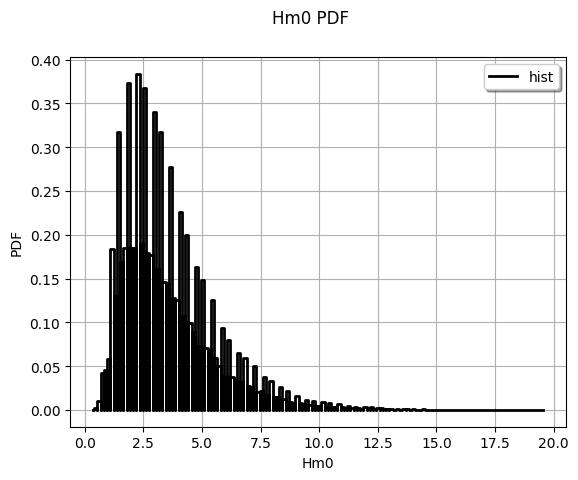

In [6]:
# Show a histogram of the H data
graph_h = ot.HistogramFactory().build(sample_H).drawPDF()
graph_h.setColors(["black"])
graph_h.setLegends(["hist"])
view = viewer.View(graph_h)
plt.show()

In [7]:
# print summary of sample_T
stats_t=getBasicStatistics(sample_T)
print("Basic statistics for T")
print("min, Q1, median, mean, Q3, max")
print(stats_t)

Basic statistics for T
min, Q1, median, mean, Q3, max
(3.4, 6.1, 7.1, 7.355064555531452, 8.4, 17.4)


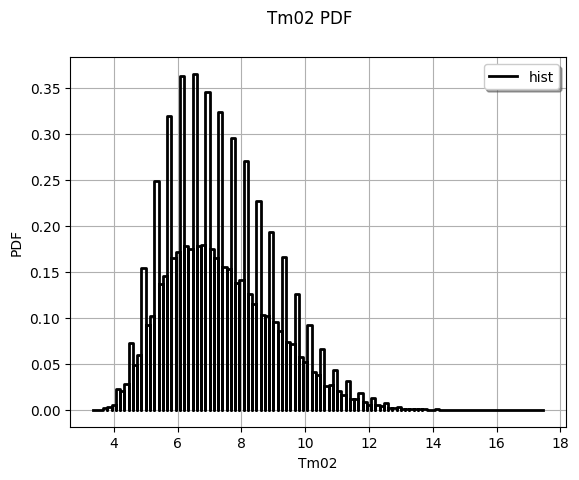

In [8]:
# Show a histogram of the T data
graph_t = ot.HistogramFactory().build(sample_T).drawPDF()
graph_t.setColors(["black"])
graph_t.setLegends(["hist"])
view = viewer.View(graph_t)
plt.show()

In [9]:
print("Basic statistics for both H & T")
print("linear_correlation, Kendall's Tau, Spearman's Rho")
print(getBivariateStatistics(sample_HT))

Basic statistics for both H & T
linear_correlation, Kendall's Tau, Spearman's Rho
(0.7867947054562321, 0.6045759762918159, 0.7867947054562321)


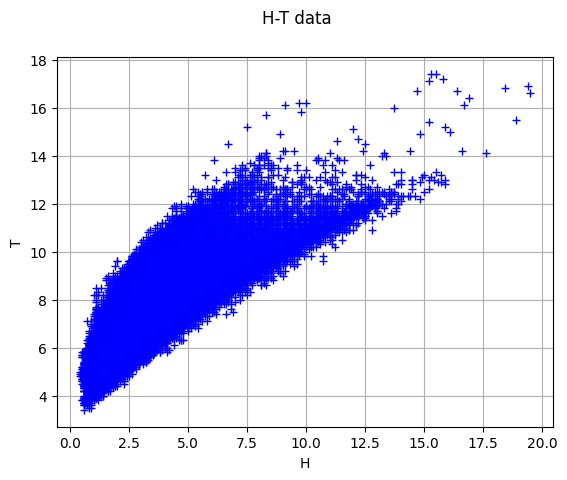

In [10]:
# Scatter plot
scatter_graph = ot.Graph("H-T data", "H", "T", True, "")
cloud = ot.Cloud(sample_HT)
scatter_graph.add(cloud)
view = viewer.View(scatter_graph)
plt.show()

In [11]:
# Maximum likelihood fit of marginal distributions with 3 parameter model
#########################################################################

# Use a package that gives a liklihood maximumization
factory_mle_wbl3_h = ot.MaximumLikelihoodFactory(ot.WeibullMin())
# Give bounds for the optimization
# 3.5556343 1.7025580 0.3997116
lowerBound=[1.0, 1.0, -1.0]
upperBound=[5.0, 3.0, 1.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True,True], [True,True,True])
factory_mle_wbl3_h.setOptimizationBounds(bounds)
# Set the starting point for the optimization
solver = factory_mle_wbl3_h.getOptimizationAlgorithm()
solver.setStartingPoint([4.0,2.0,0.0])
# solve the distribution
dist_mle_wbl3_h = factory_mle_wbl3_h.build(sample_H)
print(dist_mle_wbl3_h)

WeibullMin(beta = 3.64635, alpha = 1.52392, gamma = 0.395226)


WRN - TNC went to an abnormal point x=[nan,nan,nan] y=[] msg=TNC got a nan input value


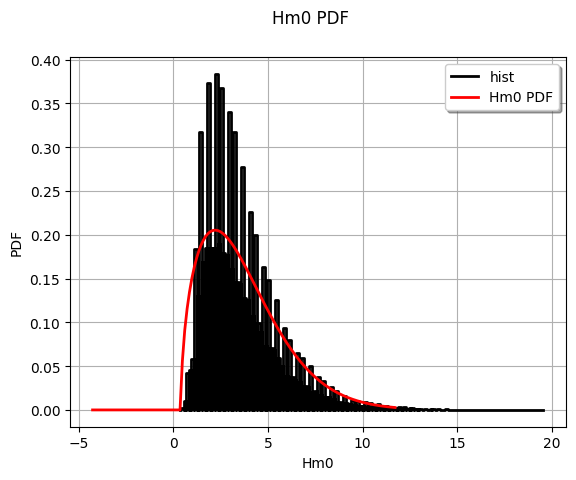

In [12]:
# Graph the results
graph_mle_wbl3_h = dist_mle_wbl3_h.drawPDF()
graph_h.add(graph_mle_wbl3_h)
view = viewer.View(graph_h)
plt.show()

In [13]:
# Use a package that gives a liklihood maximumization
factory_mle_ln_t = ot.MaximumLikelihoodFactory(ot.LogNormal())
# Set gamma = 0
##factory_mle_ln_t.setKnownParameter([0.0],[2])
# Give bounds for the optimization
lowerBound=[0.5, 0.01, 2.0]
upperBound=[4.0, 2.0, 5.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True,True], [True,True,True])
factory_mle_ln_t.setOptimizationBounds(bounds)
# Set the starting point for the optimization
solver = factory_mle_ln_t.getOptimizationAlgorithm()
# Use method of moments to create guess
guess_gamma=stats_t[0]-0.01
guess_mu=log(stats_t[2]-guess_gamma)
guess_sigma=sqrt(2.0*(log(stats_t[3]-guess_gamma)-guess_mu))
print(guess_mu,guess_sigma,guess_gamma)

1.3110318766193436 0.36466494122565907 3.39


In [14]:
# Set the starting point
solver.setStartingPoint([guess_mu,guess_sigma,guess_gamma])
# solve the distribution
dist_mle_ln_t = factory_mle_ln_t.build(sample_T)
print(dist_mle_ln_t)

LogNormal(muLog = 1.28733, sigmaLog = 1.06832, gamma = 2.32879)


WRN - Starting point is not inside bounds x=[0,1,0] bounds=class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[0.5,0.01,2] upper bound=class=Point name=Unnamed dimension=3 values=[4,2,5] finite lower bound=[1,1,1] finite upper bound=[1,1,1]
WRN - TNC went to an abnormal point x=[nan,nan,nan] y=[] msg=TNC got a nan input value


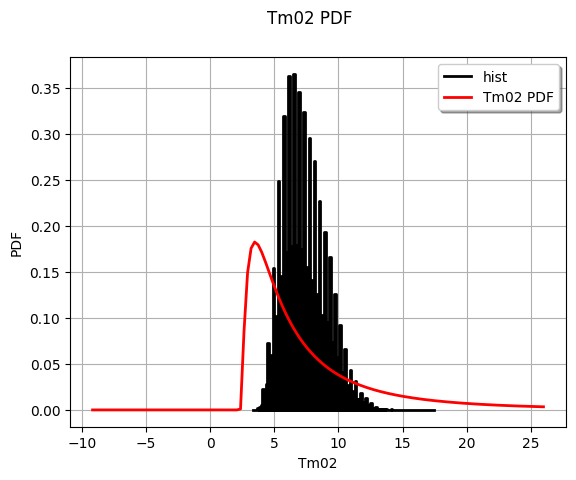

In [15]:
# Graph the results
graph_mle_ln_t = dist_mle_ln_t.drawPDF()
graph_t.add(graph_mle_ln_t)
view = viewer.View(graph_t)
plt.show()

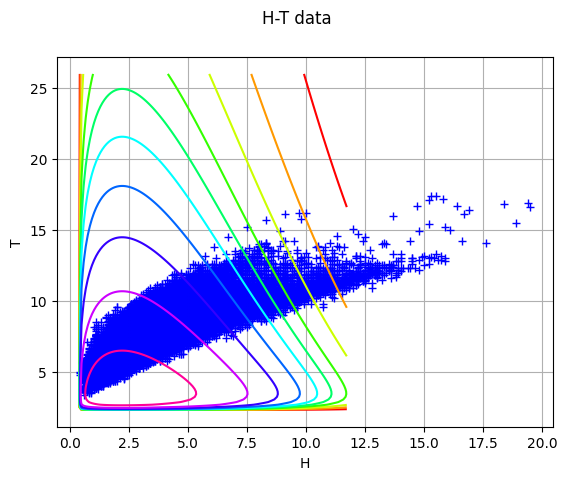

In [16]:
# Combine marginals assuming they are independent
#########################################################################

dist_bivar_indep = ot.ComposedDistribution([dist_mle_wbl3_h,dist_mle_ln_t])
graph_bivar_indep = dist_bivar_indep.drawPDF()
scatter_graph.add(graph_bivar_indep)
view = viewer.View(scatter_graph)
plt.show()

WRN - Switch to finite difference to compute the gradient at point=[1,1,0,0,1,0,0]
WRN - Switch to finite difference to compute the gradient at point=[1.00102,0.998846,0.0001,0.000197038,1.00117,4.17423e-05,0.000363439]
WRN - Switch to finite difference to compute the gradient at point=[0.999922,1.00019,4.41444e-05,0.000108376,1.00018,3.00871e-05,0.000116869]
WRN - Switch to finite difference to compute the gradient at point=[1.14985,0.872628,0.0351798,0.077789,1.27743,0.0193019,0.110605]
WRN - Switch to finite difference to compute the gradient at point=[1.89909,0.235769,0.211079,0.466734,2.66458,0.115811,0.663632]
WRN - Switch to finite difference to compute the gradient at point=[1.52447,0.554199,0.123129,0.272261,1.97101,0.0675566,0.387119]
WRN - Switch to finite difference to compute the gradient at point=[1.52446,0.554232,0.123188,0.27229,1.97098,0.0675909,0.387145]
WRN - Switch to finite difference to compute the gradient at point=[1.52446,0.554231,0.123345,0.272313,1.97094,0.06

ComposedDistribution(WeibullMin(beta = 1.52446, alpha = 0.554231, gamma = 0.123345), LogNormal(muLog = 0.272313, sigmaLog = 1.97094, gamma = 0.0676637), NormalCopula(R = [[ 1        0.387217 ]
 [ 0.387217 1        ]]))


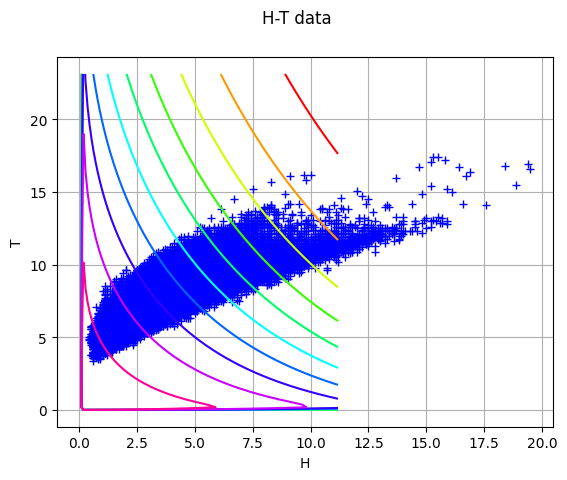

In [17]:
# Lets create some fits with different copulas
#########################################################################

factory_bivar_norm = ot.MaximumLikelihoodFactory(ot.ComposedDistribution([ot.WeibullMin(),ot.LogNormal()], ot.NormalCopula()))
dist_bivar_norm = factory_bivar_norm.build(sample_HT)
print(dist_bivar_norm)
scatter_graph = ot.Graph("H-T data", "H", "T", True, "")
cloud = ot.Cloud(sample_HT)
scatter_graph.add(cloud)
scatter_graph.add(dist_bivar_norm.drawPDF())
view = viewer.View(scatter_graph)
plt.show()

WRN - Warning! TNC algorithm failed. The error message is Linear search failed


ComposedDistribution(WeibullMin(beta = 1, alpha = 0.999988, gamma = 8.23177e-08), LogNormal(muLog = 0.0125563, sigmaLog = 1.12243, gamma = 0.00104283), GumbelCopula(theta = 2))


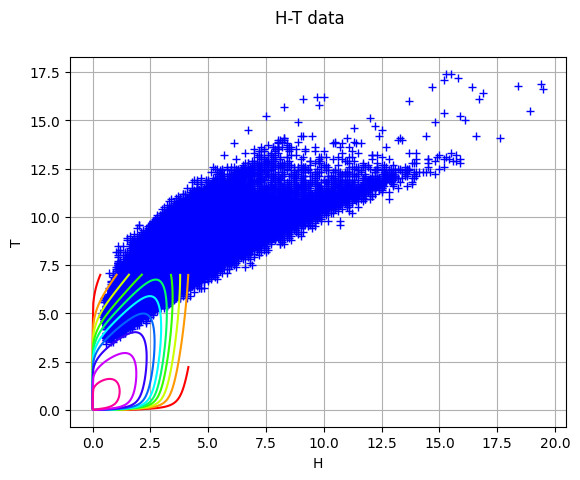

In [18]:
factory_bivar_gumbel = ot.MaximumLikelihoodFactory(ot.ComposedDistribution([ot.WeibullMin(),ot.LogNormal()], ot.GumbelCopula()))
dist_bivar_gumbel = factory_bivar_gumbel.build(sample_HT)
print(dist_bivar_gumbel)
scatter_graph = ot.Graph("H-T data", "H", "T", True, "")
cloud = ot.Cloud(sample_HT)
scatter_graph.add(cloud)
scatter_graph.add(dist_bivar_gumbel.drawPDF())
view = viewer.View(scatter_graph)
plt.show()

ComposedDistribution(WeibullMin(beta = 1.00181, alpha = 0.997405, gamma = 0.00013164), LogNormal(muLog = 0.0271, sigmaLog = 1.25727, gamma = 0.00241929), ClaytonCopula(theta = 2))


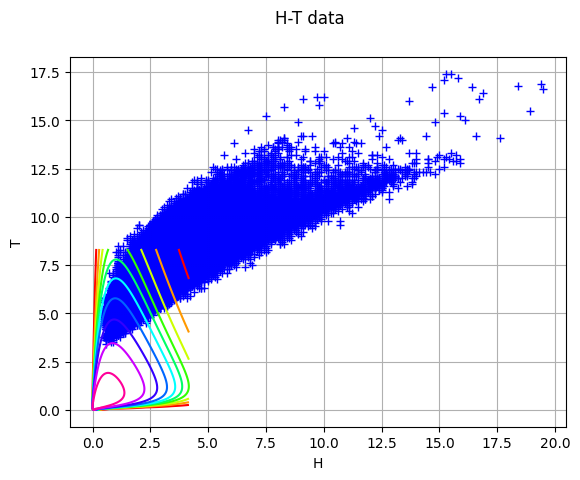

In [19]:
factory_bivar_clayton = ot.MaximumLikelihoodFactory(ot.ComposedDistribution([ot.WeibullMin(),ot.LogNormal()], ot.ClaytonCopula()))
dist_bivar_clayton = factory_bivar_clayton.build(sample_HT)
print(dist_bivar_clayton)
scatter_graph = ot.Graph("H-T data", "H", "T", True, "")
cloud = ot.Cloud(sample_HT)
scatter_graph.add(cloud)
scatter_graph.add(dist_bivar_clayton.drawPDF())
view = viewer.View(scatter_graph)
plt.show()

In [20]:
# Define a conditional model
#########################################################################

iter=1

# This is the log likelihood objective function for minimization
def get_log_likelihood_of_conditional(par):

    a0=par[0]
    a1=par[1]
    a2=par[2]
    b0=par[3]
    b1=par[4]
    b2=par[5]
    c0=par[6]
    c1=par[7]
    c2=par[8]
    ln = ot.LogNormal()
    retval=0.0
    for H, T in sample_HT:
        mu = a0+a1*H**a2
        sg = b0+b1*H**b2
        gm = c0+c1*H**c2
        #print(mu,sg,gm)
        ln.setParameter([mu,sg,gm])
        p = ln.computePDF(T)
        if p<=0.0:
            print("domain error")
            retval-=300.0
        else:
            retval+=log(p)
    return -retval

# This is the gradient of the log likelihood objective function for minimization
def get_log_likelihood_of_conditional_gradient(par):

    a0=par[0]
    a1=par[1]
    a2=par[2]
    b0=par[3]
    b1=par[4]
    b2=par[5]
    c0=par[6]
    c1=par[7]
    c2=par[8]
    ln = ot.LogNormal()
    retval=[0.0]*9
    for H, T in sample_HT:
        mu = a0+a1*H**a2
        sg = b0+b1*H**b2
        gm = c0+c1*H**c2

        ln.setParameter([mu,sg,gm])
        pnt = ot.Point(1,T)
        p = ln.computePDF(pnt)

        if p<=0.0:
            p=1.0e-300

        dmu_da0 = 1.0
        dmu_da1 = H**a2
        dmu_da2 = a1*a2*H**(a2-1.0)

        dsg_db0 = 1.0
        dsg_db1 = H**b2
        dsg_db2 = b1*b2*H**(b2-1.0)

        dgm_dc0 = 1.0
        dgm_dc1 = H**c2
        dgm_dc2 = c1*c2*H**(c2-1.0)

        dp_dTheta = ln.computePDFGradient(pnt)
        retval[0]-=dmu_da0*dp_dTheta[0]/p
        retval[1]-=dmu_da1*dp_dTheta[0]/p
        retval[2]-=dmu_da2*dp_dTheta[0]/p
        retval[3]-=dsg_db0*dp_dTheta[1]/p
        retval[4]-=dsg_db1*dp_dTheta[1]/p
        retval[5]-=dsg_db2*dp_dTheta[1]/p
        retval[6]-=dgm_dc0*dp_dTheta[2]/p
        retval[7]-=dgm_dc1*dp_dTheta[2]/p
        retval[8]-=dgm_dc2*dp_dTheta[2]/p

    return retval

In [21]:
# Set the boundaries of the problem
bnds = [(0.1,1.0),(0.1,2.0),(0.01,1.0),(0.000,1.0),(0.01,1.0),(-1.0,1.0),(0.000,5.0),(0.00,2.0),(-1.0,3.0)]
# Try a different set of starting points (inspired by the solution of the same problem solved with R)
#strt = [0.497464740,1.138225864,0.222807320,0.003084484,0.178687761,-0.091843939]
#strt = [0.49,1.13,0.22,0.0030,0.17,-0.091]
strt = [0.5,1.0,0.2,0.003,0.2,-0.1,2.0,0.0,1.0]

In [22]:
# Try different optimization algorithms
#sln = minimize(get_log_likelihood_of_conditional, strt, method='SLSQP', bounds=bnds, tol=1.0e-100 , options={'ftol':1.0e-100})
#sln = minimize(get_log_likelihood_of_conditional, strt, method='L-BFGS-B', bounds=bnds)
sln = minimize(get_log_likelihood_of_conditional, strt, method='L-BFGS-B', bounds=bnds, jac=get_log_likelihood_of_conditional_gradient)
#sln = minimize(get_log_likelihood_of_conditional, strt, method='SLSQP', bounds=bnds, jac=get_log_likelihood_of_conditional_gradient)
cond_par = sln.x

BayesDistribution(X, Y with X|Theta~LogNormal(Theta), Theta=f(Y), f=ParametricEvaluation([h,a0,a1,a2,b0,b1,b2,c0,c1,c2]#10->[a0+a1*h^a2,b0+b1*h^b2,c0+c1*h^c2], parameters positions=[1,2,3,4,5,6,7,8,9], parameters=[a0 : 0.20307, a1 : 0.948369, a2 : 0.0692345, b0 : 0.110459, b1 : 0.206781, b2 : -0.238458, c0 : 1.58512, c1 : 0.657977, c2 : 0.964765], input positions=[0]), Y~WeibullMin(beta = 3.64635, alpha = 1.52392, gamma = 0.395226))


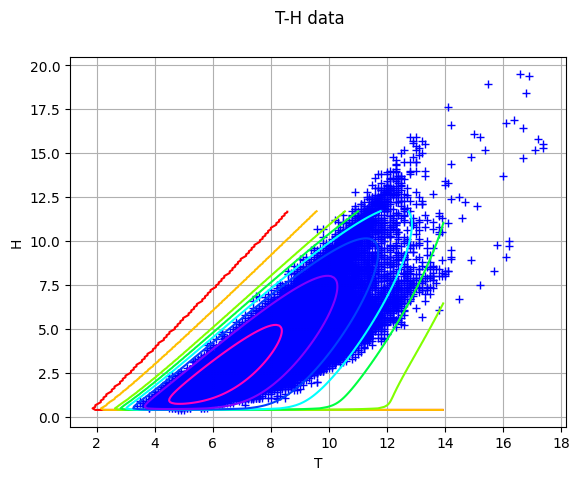

In [23]:
# Define a function that describes the conditional relationship using both stochastic and parametric variables
f_H_T_raw = ot.SymbolicFunction(['h','a0','a1','a2','b0','b1','b2','c0','c1','c2'], ['a0+a1*h^a2', 'b0+b1*h^b2', 'c0+c1*h^c2'])
# Define the parameters (variables 1-9)
f_H_T = ot.ParametricFunction(f_H_T_raw, [1,2,3,4,5,6,7,8,9], cond_par)
# Define the base distribution for T
T_given_H = ot.LogNormal()
# Copy our original weibull distribution for H
H_dist = copy.deepcopy(dist_mle_wbl3_h)
# Define a multivariate distribution with conditional dependence
TH_dist = ot.BayesDistribution(T_given_H, H_dist, f_H_T)
print(TH_dist)
scatter_graph = ot.Graph("T-H data", "T", "H", True, "")
cloud = ot.Cloud(sample_TH)
scatter_graph.add(cloud)
scatter_graph.add(TH_dist.drawPDF())
view = viewer.View(scatter_graph)
plt.show()

In [32]:
# Lets consider Akaike Information Criterion as a goodness of fit test
# We need a generic method for calculating likelihood
def log_likelihood(dist_model, sample_data):
    retval = 0.0
    for pnt in sample_data:
        p = dist_model.computePDF(pnt)
        if p<=0.0:
            p=-300.0
        retval+=log(p)
    return retval

In [33]:
L_of_TH_dist = log_likelihood(TH_dist,sample_TH)
print(L_of_TH_dist)

-289652.8101714312


In [34]:
L_of_dist_bivar_indep = log_likelihood(dist_bivar_indep,sample_HT)
print(L_of_dist_bivar_indep)

-402744.92732680496


In [40]:
# Akaike Information Criterion is as follows: 2*(p-log(L))/n
#
# L is the likelihood
# p is the number of parameters
# n is the number of samples
#
# Lower values are better
#
sample_size = sample_HT.getSize()
N_param_of_TH_dist = 12
N_param_of_dist_bivar_indep = 6
AIC_of_TH_dist = 2.0*(N_param_of_TH_dist-L_of_TH_dist)/sample_size
AIC_of_dist_bivar_indep = 2.0*(N_param_of_dist_bivar_indep-L_of_dist_bivar_indep)/sample_size
print("Conditional Distribution",AIC_of_TH_dist)
print("Independent Distribution",AIC_of_dist_bivar_indep)

Conditional Distribution 6.6134273261437055
Independent Distribution 9.195331620835967
